In [1]:
from pathlib import Path

THIS = Path(".")
BASE = THIS / ".."
BASE = BASE.absolute().resolve()

MODEL = BASE / "model"
EXPORTS = BASE / "exports"

MODEL_NAME="Llama-2-7b-hf"



MODEL_PATH = MODEL / MODEL_NAME
EXPORTS = EXPORTS / MODEL_NAME

# Engine

## Exllamav2

In [2]:
METHOD = "engine/exllamav2"
METHOD_EXPORTS = EXPORTS / METHOD


In [3]:
# print paths
print("BASE:", BASE)
print("MODEL:", MODEL)
print("MODEL_PATH:", MODEL_PATH)
print("METHOD_EXPORTS:", METHOD_EXPORTS)

BASE: /home/shwu/LLM-Efficiency-Survey
MODEL: /home/shwu/LLM-Efficiency-Survey/model
MODEL_PATH: /home/shwu/LLM-Efficiency-Survey/model/Llama-2-7b-hf
METHOD_EXPORTS: /home/shwu/LLM-Efficiency-Survey/exports/Llama-2-7b-hf/engine/exllamav2


In [4]:
# EXL2 quant sizes
exl2_models = [x for x in METHOD_EXPORTS.iterdir() if x.is_dir() and x.name.endswith("exl2")]
exl2_models.append(MODEL_PATH)

GPTQ_EXPORTS=EXPORTS / "quant/gptq"
gptq_models = [x for x in GPTQ_EXPORTS.iterdir() if x.is_dir()]
exl2_models.extend(gptq_models)

for model in exl2_models:

    # model_size := size of output.safetensors
    model_size = sum([x.stat().st_size for x in model.glob("*.safetensors")])
    print(f"{model.name}: {model_size / (1024 ** 3):.2f} GiB")

8bpw-exl2: 6.37 GiB
4bpw-exl2: 3.36 GiB
Llama-2-7b-hf: 12.55 GiB
q4_128g: 3.63 GiB
q8_128g: 6.67 GiB


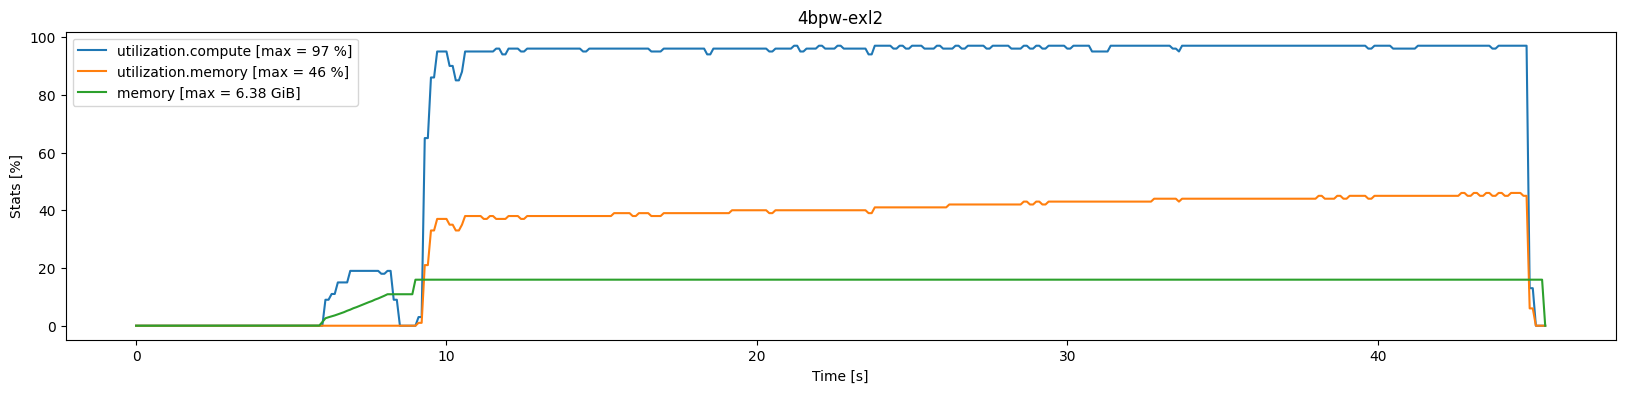

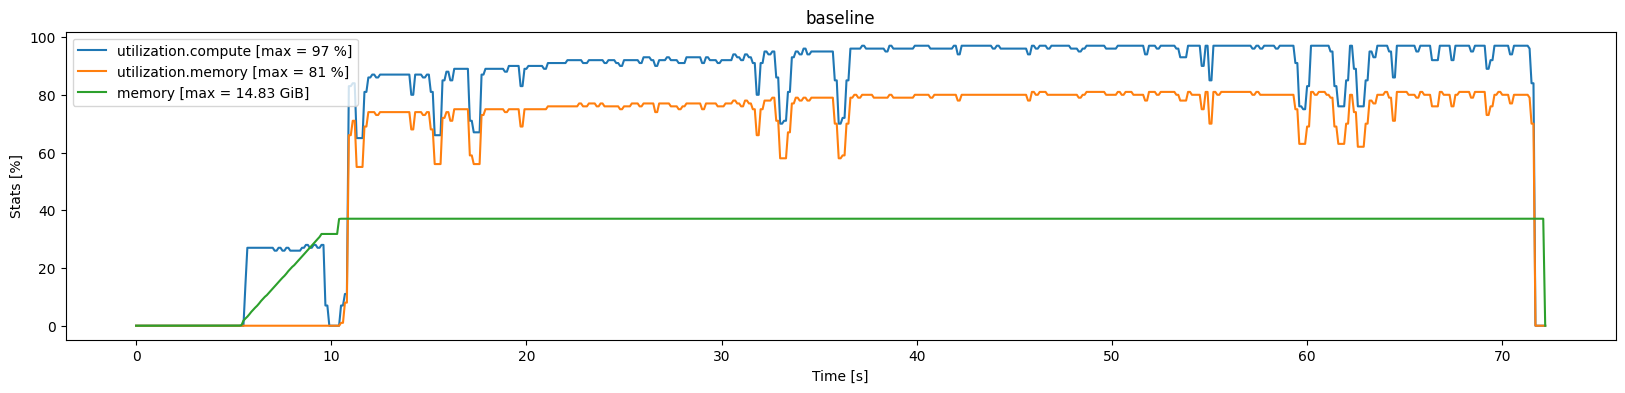

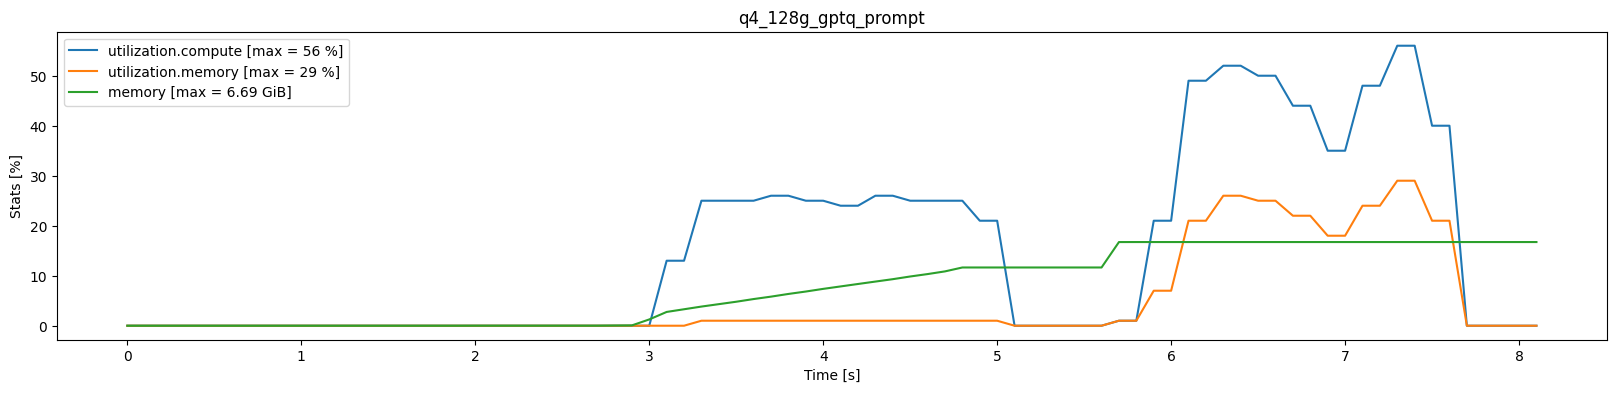

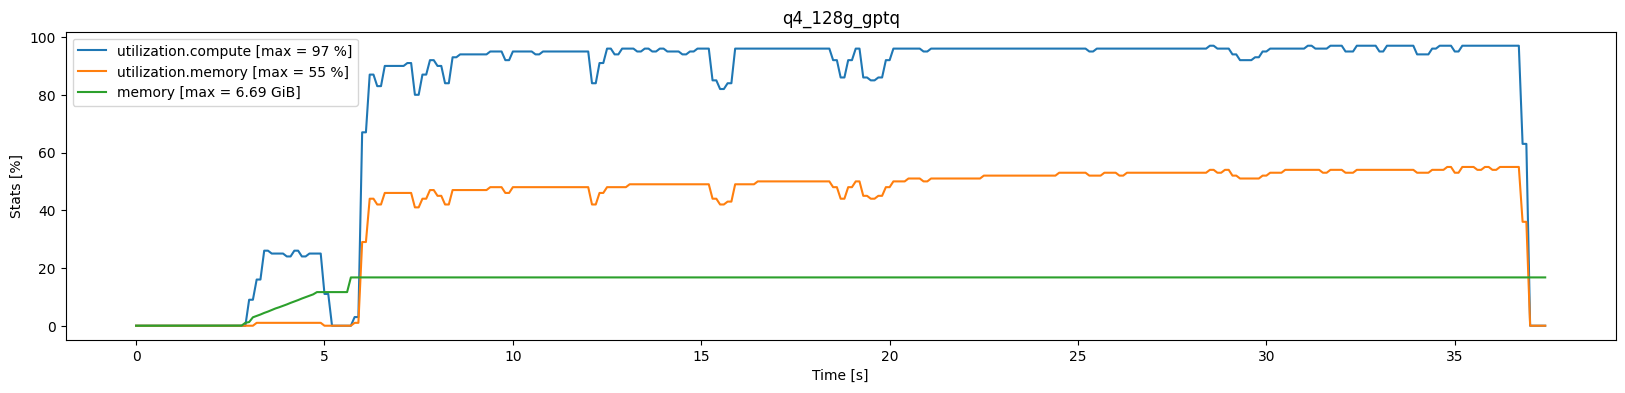

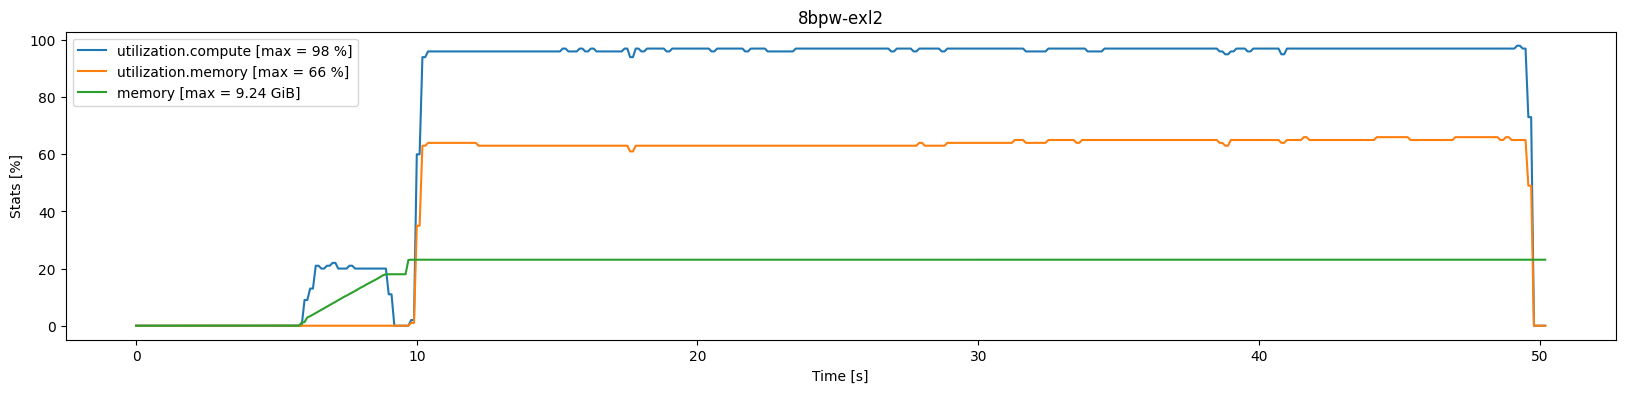

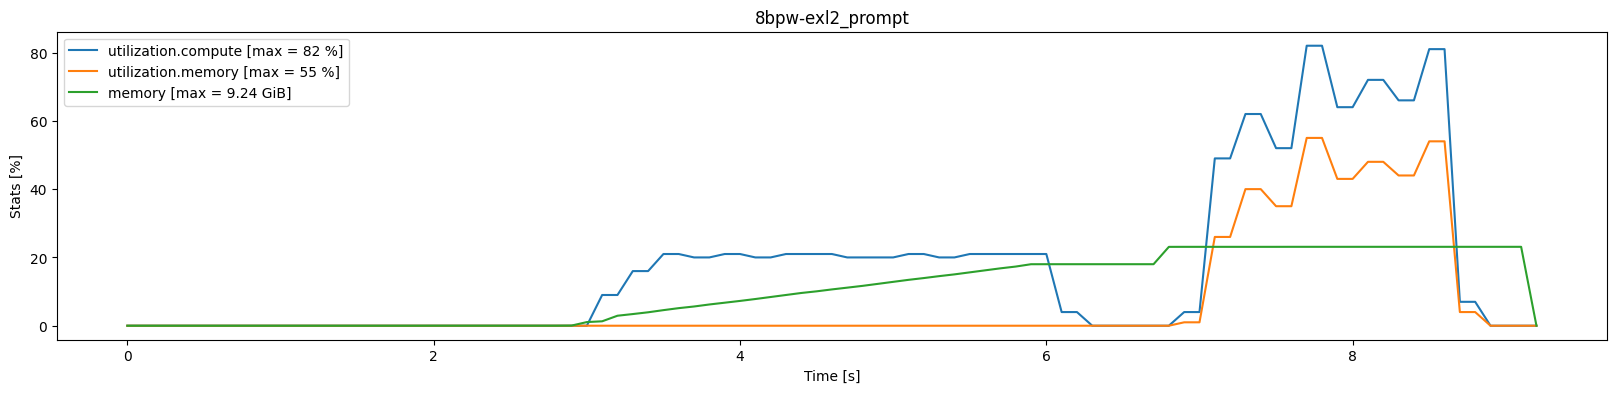

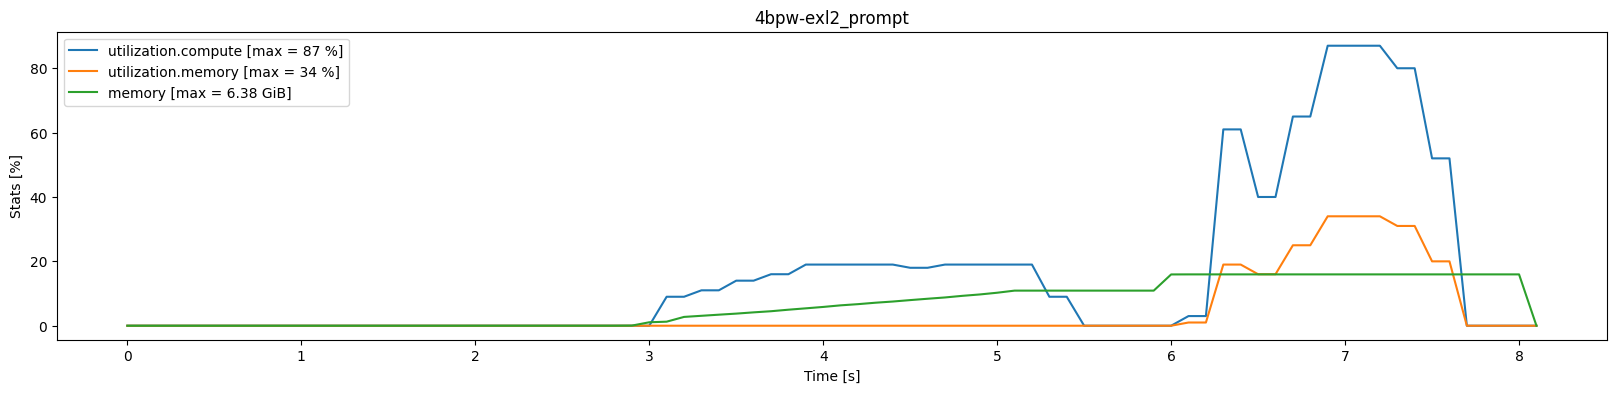

In [5]:
# max mem usage
import pandas as pd
import matplotlib.pyplot as plt
all_csvs = list(METHOD_EXPORTS.glob("*.csv"))

# csv header
# utilization.gpu [%], utilization.memory [%], memory.used [MiB], memory.free [MiB], memory.total [MiB]
utlization_gpu_key = "utilization.gpu [%]"
utilization_memory_key = " " + "utilization.memory [%]"
memory_used_key = " " + "memory.used [MiB]"
memory_free_key = " " + "memory.free [MiB]"
memory_total_key = " " + "memory.total [MiB]"

for csv in all_csvs:
    if not "bench" in csv.name:
        continue
    df = pd.read_csv(csv)

    # plot csv of utilization.memory [%] and utilization.gpu [%] both on y-axis
    fig, ax1 = plt.subplots(figsize=(20, 4))
    plt.title(csv.name.split('usage')[-1][1:-4])
    ax1.set_ylabel("Stats [%]")
    ax1.set_xlabel("Time [s]")
    ax1.plot(df.index * 0.1, df[utlization_gpu_key], label=f"utilization.compute [max = {df[utlization_gpu_key].max()} %]")
    ax1.plot(df.index * 0.1, df[utilization_memory_key], label=f"utilization.memory [max = {df[utilization_memory_key].max()} %]")
    ax1.plot(df.index * 0.1, (df[memory_used_key] / df[memory_total_key]) * 100, label=f"memory [max = {df[memory_used_key].max() / 1024:.2f} GiB]")
    ax1.legend(loc="upper left")


In [6]:
# benchmark logs
all_logs = list(METHOD_EXPORTS.glob("*.log"))

for log in all_logs:
    if not "bench" in log.name:
        continue

    print(f"{log.name.replace('_', ' ')[:-4]}", end="")
    with open(log) as f:
        lines = f.readlines()
        if "prompt" in log.name:
            print(f"\n{lines[-1].strip()}\n")
        else:
            accum_tps = []
            for line in lines:
                if "Position" in line: # for raw token speed
                    accum_tps.append(float(line.split(" ")[-2]))
            print(f" {sorted(accum_tps)[len(accum_tps) // 2]:.2f} tokens/s")
            # print(f"Average TPS: {sum(accum_tps) / len(accum_tps)}")
            print(f"Max TPS: {max(accum_tps)}\n")
            # print(f"Min TPS: {min(accum_tps)}")

bench prompt 4bpw-exl2
-- Response generated in 1.32 seconds, 128 tokens, 97.23 tokens/second (includes prompt eval.)

bench baseline 68.14 tokens/s
Max TPS: 69.3849

bench q4 128g 130.94 tokens/s
Max TPS: 149.803

bench prompt q4 128g
-- Response generated in 1.67 seconds, 128 tokens, 76.69 tokens/second (includes prompt eval.)

bench 4bpw-exl2 113.33 tokens/s
Max TPS: 129.2027

bench 8bpw-exl2 101.43 tokens/s
Max TPS: 116.524

bench prompt 8bpw-exl2
-- Response generated in 1.62 seconds, 128 tokens, 78.82 tokens/second (includes prompt eval.)

